In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [3]:
# Cargar los datos desde Kaggle con la codificación adecuada
data = pd.read_excel('/kaggle/input/eventosmasivos/EventosMasivos.xlsx', engine='openpyxl')

# Paso 2: Preparación de datos
data = data[data['anio_evento'] >= 2021]  # Filtrar por anio_evento>2021
data = data.dropna(subset=['plan_gral'])  # Eliminar filas con NaN en la columna 'plan_gral'

print(data.head())  # Verifica si los datos se han cargado y filtrado correctamente

     ingestion_year  ingestion_month  ingestion_day   num_ev  \
958            2023               10             12  2021001   
960            2023               10             12  2021003   
961            2023               10             12  2021004   
962            2023               10             12  2021005   
963            2023               10             12  2021006   

                                                nombre       estado  \
958  falla en anulaciones de recargas de tarjeta cí...  solucionado   
960  transacciones pendientes por aplicar en tarjet...  solucionado   
961                            debitó no entregó   pse  solucionado   
962       lotes de pago en estado  error de envío  sve  solucionado   
963  error asignación de tasa compra y venta de div...  solucionado   

                  f_alrt                f_ini  \
958  2021-01-06 05:00:00  2020-12-31 05:00:00   
960  2021-01-14 05:00:00  2021-01-14 05:00:00   
961  2021-01-15 05:00:00  2021-01-12 05:0

In [4]:
from transformers import BertTokenizer

# Crear una instancia del tokenizador BERT multilingüe
try:
    tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
    print("Tokenizador cargado exitosamente.")
except Exception as e:
    print(f"Error al cargar el tokenizador: {e}")

Tokenizador cargado exitosamente.


In [5]:
from nltk.corpus import stopwords

# Cargar las stopwords en español
stop_words = set(stopwords.words("spanish"))

# Función para limpiar y preprocesar texto
def clean_text(text):
    if isinstance(text, str):
        # Aplicar corrección de codificación
        text = str(text).encode('latin-1').decode('utf-8', 'ignore')
        # Tokenizar el texto y eliminar stopwords
        tokens = tokenizer.tokenize(text)
        tokens_without_numbers = [word for word in tokens if not any(char.isdigit() for char in word)]
        tokens_without_stopwords = [word for word in tokens_without_numbers if word.lower() not in stop_words]
        # Unir tokens nuevamente en un texto limpio
        cleaned_text = ' '.join(tokens_without_stopwords)
        return cleaned_text
    else:
        return ""

# Aplicar la función de limpieza al corpus y eliminar celdas vacías y 'None'
corpus = data['plan_gral']
corpusp = corpus.apply(clean_text).str.lower()
corpus = corpus[(corpusp != '') & (corpusp != 'None') & (corpusp != 'nan')]
print(corpus.head())

958    después del análisis realizado por el equipo d...
960    el aliado especifica lo siguiente     hemos re...
961      instancias bvc    se identificó que algunas ...
962    para este tema se generó un soporte estructura...
963      se realiza mesa de estabilización el 19 de e...
Name: plan_gral, dtype: object


In [16]:
print("Número de documentos después del procesamiento:", len(corpus))
print("Primeros documentos procesados:")
print(corpus.head())

Número de documentos después del procesamiento: 340
Primeros documentos procesados:
958    después del análisis realizado por el equipo d...
960    el aliado especifica lo siguiente     hemos re...
961      instancias bvc    se identificó que algunas ...
962    para este tema se generó un soporte estructura...
963      se realiza mesa de estabilización el 19 de e...
Name: plan_gral, dtype: object


In [18]:
def get_embeddings(texts, tokenizer, model):
    # Tokenizar los textos y convertirlos a tensores
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    
    # Pasar los tensores a través del modelo BERT
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Obtener los embeddings promedios de los tokens en cada documento
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    
    return embeddings

# Obtener embeddings del corpus
embeddings = get_embeddings(corpus.tolist(), tokenizer, model)
print("Embeddings obtenidos.")

Embeddings obtenidos.


Evaluando con random_state = 0
Evaluando con random_state = 42
Evaluando con random_state = 100
Evaluando con random_state = 123


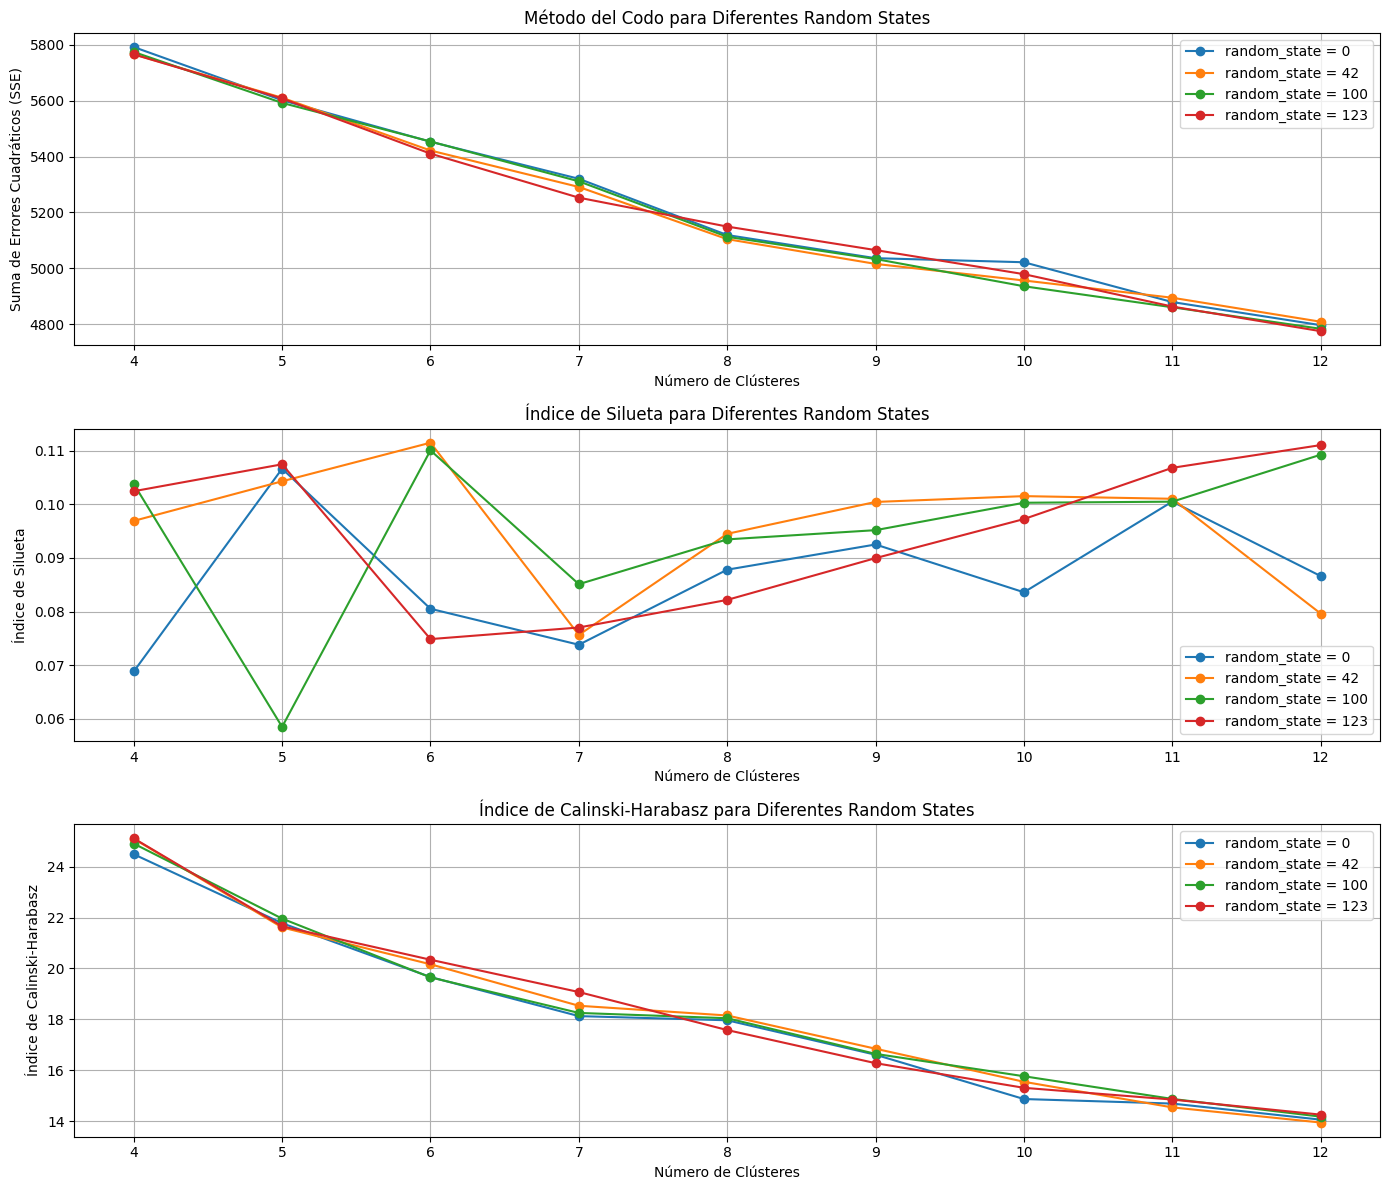

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Suponiendo que 'embeddings' contiene los embeddings generados para los documentos

# Definir los valores de random_state a probar
random_states = [0, 42, 100, 123]
k_range = range(4, 13)  # Prueba para 4 a 12 clústeres

# Inicializar listas para almacenar resultados
silhouette_scores = {state: [] for state in random_states}
calinski_harabasz_scores = {state: [] for state in random_states}
sse = {state: [] for state in random_states}

# Evaluar diferentes valores de random_state
for state in random_states:
    print(f"Evaluando con random_state = {state}")
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=state)
        kmeans.fit(embeddings)
        sse[state].append(kmeans.inertia_)
        
        if k > 1:
            clusters_k = kmeans.predict(embeddings)
            silhouette_avg = silhouette_score(embeddings, clusters_k)
            calinski_harabasz_avg = calinski_harabasz_score(embeddings, clusters_k)
            
            silhouette_scores[state].append(silhouette_avg)
            calinski_harabasz_scores[state].append(calinski_harabasz_avg)
        else:
            silhouette_scores[state].append(np.nan)
            calinski_harabasz_scores[state].append(np.nan)
            
# Graficar los resultados
plt.figure(figsize=(14, 12))

# Gráfico de Codo
plt.subplot(3, 1, 1)
for state in random_states:
    plt.plot(k_range, sse[state], marker='o', label=f'random_state = {state}')
plt.title('Método del Codo para Diferentes Random States')
plt.xlabel('Número de Clústeres')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.legend()
plt.grid(True)

# Gráfico del Índice de Silueta
plt.subplot(3, 1, 2)
for state in random_states:
    plt.plot(k_range, silhouette_scores[state], marker='o', label=f'random_state = {state}')
plt.title('Índice de Silueta para Diferentes Random States')
plt.xlabel('Número de Clústeres')
plt.ylabel('Índice de Silueta')
plt.legend()
plt.grid(True)

# Gráfico del Índice de Calinski-Harabasz
plt.subplot(3, 1, 3)
for state in random_states:
    plt.plot(k_range, calinski_harabasz_scores[state], marker='o', label=f'random_state = {state}')
plt.title('Índice de Calinski-Harabasz para Diferentes Random States')
plt.xlabel('Número de Clústeres')
plt.ylabel('Índice de Calinski-Harabasz')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluando con random_state = 0
Evaluando con random_state = 42
Evaluando con random_state = 100
Evaluando con random_state = 123
    random_state  n_clusters          SSE  Silhouette Score  \
0              0           4  5791.715820          0.068822   
1              0           5  5601.458984          0.106667   
2              0           6  5453.023438          0.080521   
3              0           7  5320.432617          0.073813   
4              0           8  5119.257324          0.087820   
5              0           9  5036.458008          0.092520   
6              0          10  5021.907227          0.083603   
7              0          11  4879.541016          0.100527   
8              0          12  4796.880859          0.086631   
9             42           4  5765.987793          0.096924   
10            42           5  5610.338867          0.104317   
11            42           6  5421.570801          0.111515   
12            42           7  5291.195312          0

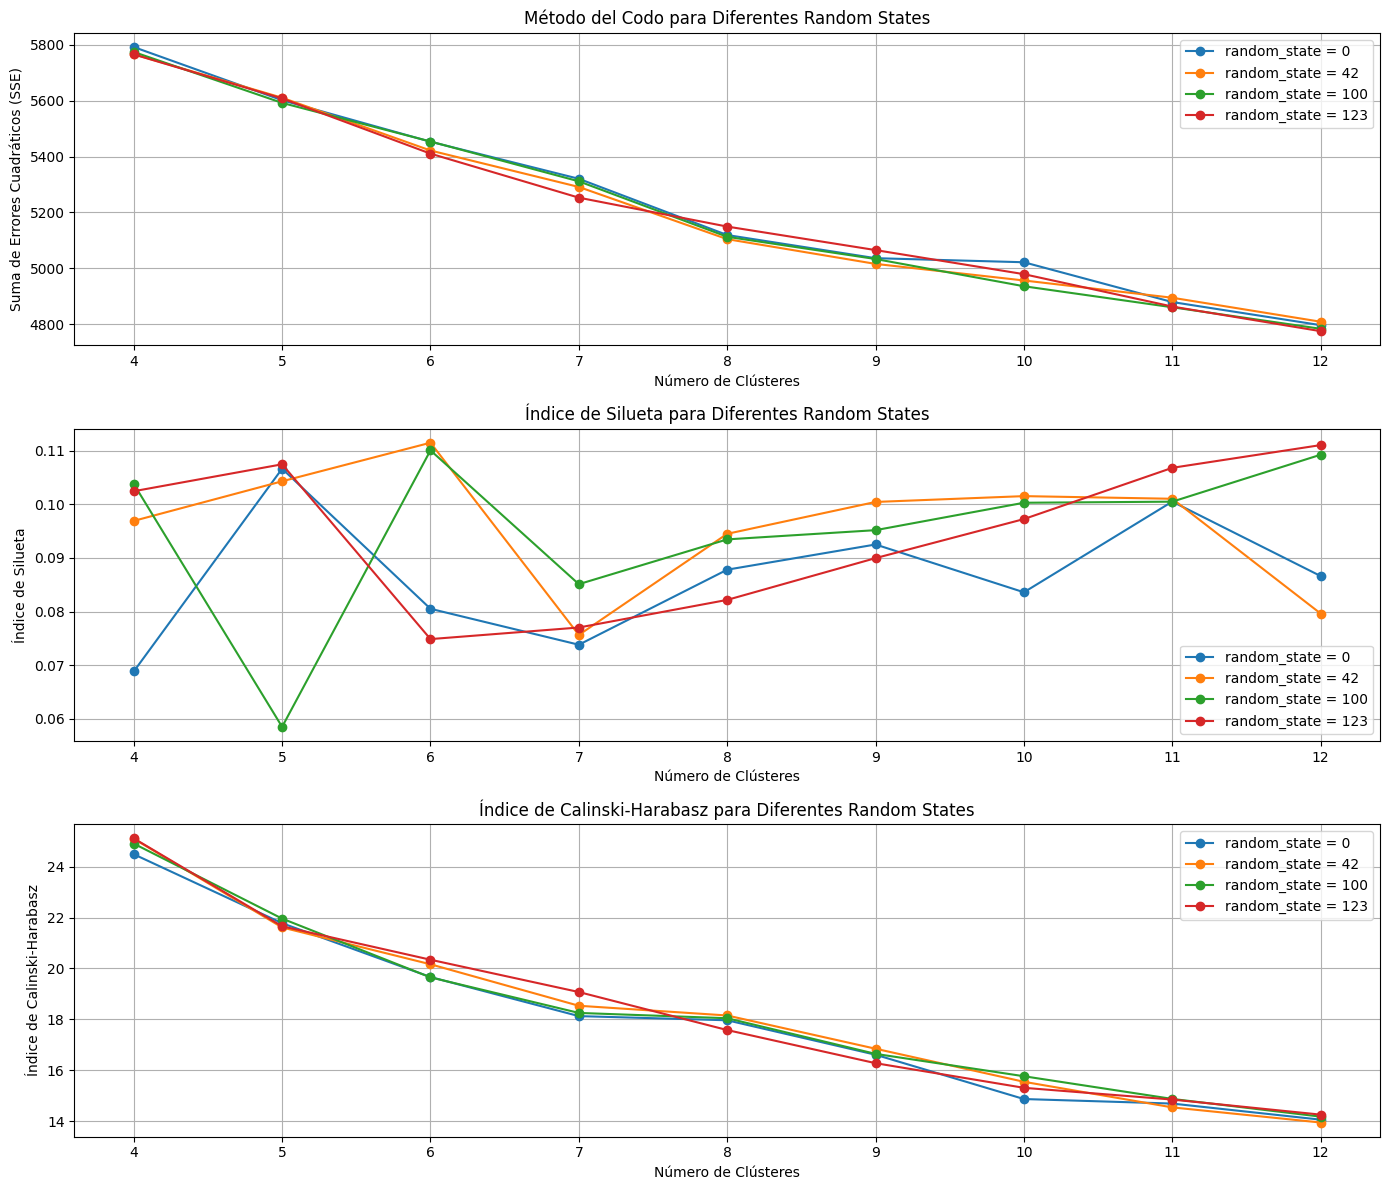

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Suponiendo que 'embeddings' contiene los embeddings generados para los documentos

# Definir los valores de random_state a probar
random_states = [0, 42, 100, 123]
k_range = range(4, 13)  # Prueba para 4 a 12 clústeres

# Inicializar listas para almacenar resultados
results = []

# Evaluar diferentes valores de random_state
for state in random_states:
    print(f"Evaluando con random_state = {state}")
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=state)
        kmeans.fit(embeddings)
        sse = kmeans.inertia_
        
        if k > 1:
            clusters_k = kmeans.predict(embeddings)
            silhouette_avg = silhouette_score(embeddings, clusters_k)
            calinski_harabasz_avg = calinski_harabasz_score(embeddings, clusters_k)
        else:
            silhouette_avg = np.nan
            calinski_harabasz_avg = np.nan
        
        results.append({
            'random_state': state,
            'n_clusters': k,
            'SSE': sse,
            'Silhouette Score': silhouette_avg,
            'Calinski-Harabasz Score': calinski_harabasz_avg
        })

# Crear un DataFrame con los resultados
df_results = pd.DataFrame(results)

# Mostrar la tabla con los resultados
print(df_results)

# Graficar los resultados
plt.figure(figsize=(14, 12))

# Gráfico de Codo
plt.subplot(3, 1, 1)
for state in random_states:
    subset = df_results[df_results['random_state'] == state]
    plt.plot(subset['n_clusters'], subset['SSE'], marker='o', label=f'random_state = {state}')
plt.title('Método del Codo para Diferentes Random States')
plt.xlabel('Número de Clústeres')
plt.ylabel('Suma de Errores Cuadráticos (SSE)')
plt.legend()
plt.grid(True)

# Gráfico del Índice de Silueta
plt.subplot(3, 1, 2)
for state in random_states:
    subset = df_results[df_results['random_state'] == state]
    plt.plot(subset['n_clusters'], subset['Silhouette Score'], marker='o', label=f'random_state = {state}')
plt.title('Índice de Silueta para Diferentes Random States')
plt.xlabel('Número de Clústeres')
plt.ylabel('Índice de Silueta')
plt.legend()
plt.grid(True)

# Gráfico del Índice de Calinski-Harabasz
plt.subplot(3, 1, 3)
for state in random_states:
    subset = df_results[df_results['random_state'] == state]
    plt.plot(subset['n_clusters'], subset['Calinski-Harabasz Score'], marker='o', label=f'random_state = {state}')
plt.title('Índice de Calinski-Harabasz para Diferentes Random States')
plt.xlabel('Número de Clústeres')
plt.ylabel('Índice de Calinski-Harabasz')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Asumimos que ya tienes 'embeddings' y has definido 'n_clusters'
n_clusters = 8
random_state = 42

# Normalizar los datos
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Reducir dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Aplicar KMeans con el número de clústeres deseado
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
clusters = kmeans.fit_predict(reduced_embeddings)

# Crear un mapa de colores para cada clúster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', marker='o')
plt.colorbar(scatter, label='Número de Clúster')
plt.title('Visualización de Clústeres en 2D (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'embeddings' is not defined

In [ ]:
from sklearn.manifold import TSNE

# Reducción de dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Graficar los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.title('Visualización de Clústeres con t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Paso 1: Aplicar PCA para reducir la dimensionalidad a 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Paso 2: Crear un DataFrame con los resultados de PCA
df_pca = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = clusters

# Paso 3: Graficar los clústeres
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title('Visualización de Clústeres')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


In [ ]:
#Definición del rango de números de clústeres: Se especifica un rango de números de clústeres que deseas probar. En este caso, se prueba desde 2 hasta 10 clústeres.
#Listas para almacenar métricas: Se crean dos listas vacías, silhouette_scores y calinski_harabasz_scores, para almacenar los valores de las métricas para cada número de clúster.
#Cálculo de métricas para diferentes números de clústeres: Se realiza un bucle que itera a través de los números de clústeres en el rango especificado. Para cada número de clúster:
#Se aplica el algoritmo K-Means con el número de clústeres actual.
#Se calcula la puntuación de Silueta, que mide la calidad de la agrupación. Una puntuación de Silueta más alta indica una mejor separación entre clústeres.
#Se calcula la puntuación de Calinski-Harabasz, que también mide la calidad de la agrupación. Una puntuación más alta aquí indica una mayor cohesión intraclúster y una mayor separación interclúster.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Rango de números de clusters que deseas probar
n_clusters_range = range(2, 15)

# Listas para almacenar los valores de las métricas
silhouette_scores = []
calinski_harabasz_scores = []

# Calcular las métricas para diferentes números de clusters
for n_clusters in n_clusters_range:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(umap_embeddings)
    
    # Calcular la puntuación de la Silueta
    silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calcular la puntuación de Calinski-Harabasz
    calinski_harabasz_avg = calinski_harabasz_score(umap_embeddings, cluster_labels)
    calinski_harabasz_scores.append(calinski_harabasz_avg)

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Número de Clusters': n_clusters_range,
    'Puntuación de Silueta': silhouette_scores,
    'Puntuación de Calinski-Harabasz': calinski_harabasz_scores
})

# Mostrar la tabla de resultados
print(results_df)

# Graficar la puntuación de la Silueta en función del número de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Puntuación de Silueta en función del número de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de Silueta')

# Graficar la puntuación de Calinski-Harabasz en función del número de clusters
plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, calinski_harabasz_scores, marker='o')
plt.title('Puntuación de Calinski-Harabasz en función del número de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de Calinski-Harabasz')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Paso 5: Clustering con K-Means
n_clusters = 6  # Ajusta el número de clústeres según sea necesario
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(umap_embeddings)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear un vectorizador TF-IDF para representar los documentos como vectores numéricos
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Crear una matriz de similitud de coseno entre todos los documentos
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
import pandas as pd
import numpy as np

# Crear listas para almacenar los datos
num_ev_list_i = []
num_ev_list_j = []
plan_gral_list_i = []
plan_gral_list_j = []
cluster_list = []
similitud_list = []

# Establecer el umbral de similitud
umbral_similitud = 0.8

# Encontrar los pares de documentos más similares dentro de cada clúster
n_clusters = len(set(cluster_labels))

for cluster_id in range(n_clusters):
    # Filtrar los documentos pertenecientes al clúster actual
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    
    # Crear una submatriz de similitud de coseno solo para los documentos en este clúster
    cluster_cosine_sim_matrix = cosine_sim_matrix[cluster_indices][:, cluster_indices]
    
    # Encontrar los índices de los pares de documentos más similares dentro del clúster
    indices = np.triu_indices(len(cluster_indices), k=1)  # Solo mirar la mitad superior de la matriz
    
    # Comprobar que los índices estén dentro de los límites
    valid_indices = [(i, j) for i, j in zip(*indices) if i < len(cluster_indices) and j < len(cluster_indices)]
    
    # Almacenar los datos en las listas
    for i, j in valid_indices:
        if cluster_cosine_sim_matrix[i, j] > umbral_similitud:
            # Obtener los índices originales en el corpus completo
            doc_index_i = cluster_indices[i]
            doc_index_j = cluster_indices[j]
            
            # Obtener los num_ev y plan_gral correspondientes a estos índices
            num_ev_i = data['num_ev'].iloc[doc_index_i]
            num_ev_j = data['num_ev'].iloc[doc_index_j]
            plan_gral_i = data['plan_gral'].iloc[doc_index_i]
            plan_gral_j = data['plan_gral'].iloc[doc_index_j]
            
            # Agregar los datos a las listas
            num_ev_list_i.append(num_ev_i)
            num_ev_list_j.append(num_ev_j)
            plan_gral_list_i.append(plan_gral_i)
            plan_gral_list_j.append(plan_gral_j)
            cluster_list.append(cluster_id)
            similitud_list.append(cluster_cosine_sim_matrix[i, j])

# Crear un DataFrame con los datos recopilados
df = pd.DataFrame({
    'num_ev_i': num_ev_list_i,
    'num_ev_j': num_ev_list_j,
    'plan_gral_i': plan_gral_list_i,
    'plan_gral_j': plan_gral_list_j,
    'cluster': cluster_list,
    'similitud': similitud_list
})

# Exportar el DataFrame a un archivo Excel
df.to_excel('resultados.xlsx', index=False)

print(df)

In [ ]:
import warnings
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import numpy as np
import re
import unicodedata

# Suprimir advertencias
warnings.filterwarnings("ignore")

# Cargar las stopwords en español
stop_words = set(stopwords.words("spanish"))

# Cargar los datos con la codificación adecuada
data = pd.read_excel('/kaggle/input/eventosmasivos/EventosMasivos.xlsx', engine='openpyxl')

# Paso 2: Preparación de datos
data = data[data['anio_evento'] >= 2021]  # Filtrar por anio_evento >= 2021
data = data.dropna(subset=['plan_gral'])  # Eliminar filas con NaN en la columna 'plan_gral'

# Asignar la columna 'documento' al corpus
corpus = data['plan_gral']

# Crear un BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Función para limpiar y preprocesar texto
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def clean_text(text):
    if isinstance(text, str):
        # Aplicar corrección de codificación
        text = str(text).encode('latin-1').decode('utf-8', 'ignore')
        
        # Normalizar caracteres a su forma sin acentos (NFC)
        text = unicodedata.normalize('NFC', text)
        
        # Tokenizar el texto en palabras
        words = word_tokenize(text)
        
        # Filtrar palabras que contienen números
        words_without_numbers = [word for word in words if not any(char.isdigit() for char in word)]
        
        # Unir palabras nuevamente en un texto limpio
        cleaned_text = ' '.join(words_without_numbers)
        return cleaned_text
    else:
        return ""


# Aplicar la función de limpieza al corpus y eliminar celdas vacías y 'None'
corpusp = corpus.apply(clean_text).str.lower()
corpus = corpusp
print (corpus)

# Cargar el modelo pre-entrenado y el tokenizador de BERT en español
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Función para obtener los embeddings de BERT para un texto
def get_bert_embeddings(text):
    # Tokenizar el texto y convertirlo en tensores
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128, return_attention_mask=False, return_token_type_ids=False)
    
    # Obtener los embeddings de BERT
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extraer la representación oculta correspondiente a [CLS] (token de inicio)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    return cls_embeddings

# Obtener embeddings para todo el corpus
corpus_embeddings = [get_bert_embeddings(text) for text in corpus]

# Paso 4: Reducción de dimensionalidad con UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(np.vstack(corpus_embeddings))

# Rango de números de clusters que deseas probar
n_clusters_range = range(2, 15)

# Listas para almacenar los valores de las métricas
silhouette_scores = []
calinski_harabasz_scores = []

# Calcular las métricas para diferentes números de clusters
for n_clusters in n_clusters_range:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(umap_embeddings)
    
    # Calcular la puntuación de la Silueta
    silhouette_avg = silhouette_score(umap_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calcular la puntuación de Calinski-Harabasz
    calinski_harabasz_avg = calinski_harabasz_score(umap_embeddings, cluster_labels)
    calinski_harabasz_scores.append(calinski_harabasz_avg)

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Número de Clusters': n_clusters_range,
    'Puntuación de Silueta': silhouette_scores,
    'Puntuación de Calinski-Harabasz': calinski_harabasz_scores
})

# Graficar la puntuación de la Silueta en función del número de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Puntuación de Silueta en función del número de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de Silueta')

# Graficar la puntuación de Calinski-Harabasz en función del número de clusters
plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, calinski_harabasz_scores, marker='o')
plt.title('Puntuación de Calinski-Harabasz en función del número de clusters')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de Calinski-Harabasz')

plt.tight_layout()
plt.show()

# Paso 5: Clustering con K-Means
n_clusters = 11  # Ajusta el número de clústeres según sea necesario
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(umap_embeddings)

# Crear un vectorizador TF-IDF para representar los documentos como vectores numéricos
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Crear una matriz de similitud de coseno entre todos los documentos
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Establecer el umbral de similitud
umbral_similitud = 0.8

import pandas as pd
import numpy as np

# Crear listas para almacenar los datos
num_ev_list_i = []
num_ev_list_j = []
plan_gral_list_i = []
plan_gral_list_j = []
cluster_list = []
similitud_list = []

# Encontrar los pares de documentos más similares dentro de cada clúster
n_clusters = len(set(cluster_labels))

for cluster_id in range(n_clusters):
    # Filtrar los documentos pertenecientes al clúster actual
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    
    # Crear una submatriz de similitud de coseno solo para los documentos en este clúster
    cluster_cosine_sim_matrix = cosine_sim_matrix[cluster_indices][:, cluster_indices]
    
    # Encontrar los índices de los pares de documentos más similares dentro del clúster
    indices = np.triu_indices(len(cluster_indices), k=1)  # Solo mirar la mitad superior de la matriz
    
    # Almacenar los datos en las listas
    for i, j in zip(*indices):
        if cluster_cosine_sim_matrix[i, j] > umbral_similitud:
            # Obtener los índices originales en el corpus completo
            doc_index_i = cluster_indices[i]
            doc_index_j = cluster_indices[j]
            
            # Obtener los num_ev y plan_gral correspondientes a estos índices
            num_ev_i = data['num_ev'].iloc[doc_index_i]
            num_ev_j = data['num_ev'].iloc[doc_index_j]
            plan_gral_i = data['plan_gral'].iloc[doc_index_i]
            plan_gral_j = data['plan_gral'].iloc[doc_index_j]
            
            # Agregar los datos a las listas
            num_ev_list_i.append(num_ev_i)
            num_ev_list_j.append(num_ev_j)
            plan_gral_list_i.append(plan_gral_i)
            plan_gral_list_j.append(plan_gral_j)
            cluster_list.append(cluster_id)
            similitud_list.append(cluster_cosine_sim_matrix[i, j])

# Crear un DataFrame con los datos recopilados
df = pd.DataFrame({
    'num_ev_i': num_ev_list_i,
    'num_ev_j': num_ev_list_j,
    'plan_gral_i': plan_gral_list_i,
    'plan_gral_j': plan_gral_list_j,
    'cluster': cluster_list,
    'similitud': similitud_list
})

# Exportar el DataFrame a un archivo Excel
df.to_excel('resultados.xlsx', index=False)


In [ ]:
# ... (código previo)

# Crear un diccionario para almacenar las palabras clave de cada cluster
cluster_keywords = {}

# Encontrar los pares de documentos más similares dentro de cada clúster
n_clusters = len(set(cluster_labels))

for cluster_id in range(n_clusters):
    # Filtrar los documentos pertenecientes al clúster actual
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    
    # Crear una submatriz de similitud de coseno solo para los documentos en este clúster
    cluster_cosine_sim_matrix = cosine_sim_matrix[cluster_indices][:, cluster_indices]
    
    # Encontrar los índices de los pares de documentos más similares dentro del clúster
    indices = np.triu_indices(len(cluster_indices), k=1)  # Solo mirar la mitad superior de la matriz
    
    # Almacenar los datos en las listas y calcular las palabras clave
    for i, j in zip(*indices):
        if cluster_cosine_sim_matrix[i, j] > umbral_similitud:
            # Obtener los índices originales en el corpus completo
            doc_index_i = cluster_indices[i]
            doc_index_j = cluster_indices[j]
            
            # Obtener los num_ev y plan_gral correspondientes a estos índices
            num_ev_i = data['num_ev'].iloc[doc_index_i]
            num_ev_j = data['num_ev'].iloc[doc_index_j]
            plan_gral_i = data['plan_gral'].iloc[doc_index_i]
            plan_gral_j = data['plan_gral'].iloc[doc_index_j]
            
            # Calcular palabras clave para este par de documentos
            text_i = clean_text(plan_gral_i)
            text_j = clean_text(plan_gral_j)
            
            # Aquí debes calcular las palabras clave a partir de text_i y text_j
            # Puedes utilizar técnicas como TF-IDF, frecuencia de palabras, etc.
            
            # Ejemplo de cómo calcular palabras clave (reemplazar con tu lógica):
            words_i = text_i.split()  # Divide el texto en palabras
            words_j = text_j.split()
            common_words = list(set(words_i).intersection(words_j))  # Palabras clave comunes
            palabras_clave_del_cluster = ', '.join(common_words)  # Puedes personalizar este formato
            
            # Agregar las palabras clave al diccionario
            cluster_keywords[cluster_id] = palabras_clave_del_cluster
            
            # Agregar los datos a las listas
            num_ev_list_i.append(num_ev_i)
            num_ev_list_j.append(num_ev_j)
            plan_gral_list_i.append(plan_gral_i)
            plan_gral_list_j.append(plan_gral_j)
            cluster_list.append(cluster_id)
            similitud_list.append(cluster_cosine_sim_matrix[i, j])

# Crear un DataFrame con los datos recopilados
df = pd.DataFrame({
    'num_ev_i': num_ev_list_i,
    'num_ev_j': num_ev_list_j,
    'plan_gral_i': plan_gral_list_i,
    'plan_gral_j': plan_gral_list_j,
    'cluster': cluster_list,
    'similitud': similitud_list
})


# Crear un DataFrame con las palabras clave de cada cluster
keywords_df = pd.DataFrame(list(cluster_keywords.items()), columns=['Cluster', 'Palabras Clave'])

# Exportar el DataFrame a un archivo Excel
keywords_df.to_excel('cluster_keywords.xlsx', index=False)

# Mostrar el DataFrame con los resultados
print(keywords_df)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear un vectorizador TF-IDF para representar los documentos como vectores numéricos
vectorizer = TfidfVectorizer()

# Crear una matriz TF-IDF a partir del corpus procesado
tfidf_matrix = vectorizer.fit_transform(corpus)

# Obtener las palabras o características (términos) que corresponden a las columnas
features = vectorizer.get_feature_names_out()

# Crear un DataFrame para visualizar la matriz TF-IDF
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=features)

# Agregar una columna 'cluster' al DataFrame para las etiquetas de clúster
tfidf_df['cluster'] = cluster_labels

# Visualizar la matriz TF-IDF con la columna 'cluster'
print(tfidf_df)

In [ ]:
print(len(cluster_list))
print(len(tfidf_df))

In [ ]:
print(cluster_list)

In [ ]:
import pandas as pd

# Asegurarse de que cluster_labels tenga la misma longitud que data['num_ev']
if len(cluster_labels) == len(data):
    # Crear un DataFrame que contiene los números de eventos y los clústeres
    num_ev_y_cluster = pd.DataFrame({'num_ev': data['num_ev'], 'cluster': cluster_labels})

    # Exportar el DataFrame a un archivo Excel
    num_ev_y_cluster.to_excel('num_ev_y_cluster.xlsx', index=False)

    # Mostrar el DataFrame con los números de eventos y clústeres
    print(num_ev_y_cluster)
else:
    print("Las longitudes de los datos no coinciden. Asegúrate de que cluster_labels tenga la misma longitud que data['num_ev'].")

In [ ]:
import warnings
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Suprimir advertencias
warnings.filterwarnings("ignore")

# Cargar las stopwords en español
stop_words = set(stopwords.words("spanish"))

# Cargar los datos con la codificación adecuada
data = pd.read_excel('/kaggle/input/eventosmasivos/EventosMasivos.xlsx', engine='openpyxl')

# Paso 2: Preparación de datos
data = data[data['anio_evento'] >= 2021]  # Filtrar por anio_evento >= 2021
data = data.dropna(subset=['plan_gral'])  # Eliminar filas con NaN en la columna 'plan_gral'

# Asignar la columna 'documento' al corpus
corpus = data['plan_gral']

# Crear un BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Función para limpiar y preprocesar texto
def clean_text(text):
    if isinstance(text, str):
        # Aplicar corrección de codificación
        text = str(text).encode('latin-1').decode('utf-8', 'ignore')
        
        # Normalizar caracteres a su forma sin acentos (NFC)
        text = unicodedata.normalize('NFC', text)
        
        # Tokenizar el texto en palabras
        words = word_tokenize(text)
        
        # Filtrar palabras que contienen números
        words_without_numbers = [word for word in words if not any(char.isdigit() for char in word)]
        
        # Unir palabras nuevamente en un texto limpio
        cleaned_text = ' '.join(words_without_numbers)
        return cleaned_text
    else:
        return ""

# Aplicar la función de limpieza al corpus y eliminar celdas vacías y 'None'
corpusp = corpus.apply(clean_text).str.lower()
corpus = corpusp[(corpusp != '') & (corpusp != 'None') & (corpusp != 'nan')]

# Cargar el modelo pre-entrenado y el tokenizador de BERT en español
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Función para obtener los embeddings de BERT para un texto
def get_bert_embeddings(text):
    # Tokenizar el texto y convertirlo en tensores
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128, return_attention_mask=False, return_token_type_ids=False)
    
    # Obtener los embeddings de BERT
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extraer la representación oculta correspondiente a [CLS] (token de inicio)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    return cls_embeddings

# Obtener embeddings para todo el corpus
corpus_embeddings = [get_bert_embeddings(text) for text in corpus]

# Crear una matriz de similitud de coseno entre todos los documentos
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Establecer el umbral de similitud
umbral_similitud = 1

import pandas as pd
import numpy as np

# Crear listas para almacenar los datos
num_ev_list_i = []
num_ev_list_j = []
plan_gral_list_i = []
plan_gral_list_j = []
similitud_list = []

# Encontrar los pares de documentos más similares
n_docs = len(corpus)

for i in range(n_docs):
    for j in range(i+1, n_docs):
        if cosine_sim_matrix[i][j] > umbral_similitud:
            num_ev_i = data['num_ev'].iloc[i]
            num_ev_j = data['num_ev'].iloc[j]
            plan_gral_i = data['plan_gral'].iloc[i]
            plan_gral_j = data['plan_gral'].iloc[j]
            num_ev_list_i.append(num_ev_i)
            num_ev_list_j.append(num_ev_j)
            plan_gral_list_i.append(plan_gral_i)
            plan_gral_list_j.append(plan_gral_j)
            similitud_list.append(cosine_sim_matrix[i][j])

# Crear un DataFrame con los datos recopilados
df = pd.DataFrame({
    'num_ev_i': num_ev_list_i,
    'num_ev_j': num_ev_list_j,
    'plan_gral_i': plan_gral_list_i,
    'plan_gral_j': plan_gral_list_j,
    'similitud': similitud_list
})

# Exportar el DataFrame a un archivo Excel
df.to_excel('resultados.xlsx', index=False)

# Mostrar el DataFrame con los resultados
print(df)